In [ ]:
# Project 3 classifying the Damage vs. No-Damage datasets

I have iplemented Parts 1 and 2 of Project 3 in this notebook:
- loading Hurricane Harvey satellite image dataset.
- performing basic exploratory analysis and preprocessing.
- creating stratified train/validation/test splits.
- traning three different neural network architectures (Dense ANN, LeNet-5, Alternate-LeNet).
- picking the best model based on validation F1 and evaluate it once on the held out test set.
- saving the best model and a short JSON summary for  deployment.

Use of AI tools: I used ChatGPT as a helper to:
- go through design choices (e.g., which layers/activations to use).
- debug (a bunch of things in addition to) occasional TensorFlow/Keras errors and shape mismatches.
- improving the wording of the written report and comments.

All code in this notebook was written, run, and checked by me. I checked any AI suggestions for correctness and made all final decisions myself.

In [19]:
# Cell 1: all imports & configs 
import os, json, math, random, pathlib, itertools, shutil
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import classification_report, roc_auc_score, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split
from collections import Counter
from PIL import Image

SEED = 1337
tf.random.set_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

# change this path for Project 3 dataset directory on grading vm (in my vm folder's I have data in this directory of project in nb container)
DATA_ROOT = pathlib.Path("../datasets/unit03/Project2").resolve()
OUT_DIR   = pathlib.Path("../models").resolve()
OUT_DIR.mkdir(parents=True, exist_ok=True)

CLASS_DIRS = {"damage": "damage", "no_damage": "no_damage"}

# Input sizes for the three models
# Dense ANN
ANN_IMG_SIZE = (64, 64)
# Classic LeNet-5
LENET_IMG_SIZE = (32, 32)
# Alternate-LeNet from paper Table 1 
ALT_IMG_SIZE = (150, 150)

BATCH = 32
EPOCHS = 25 # based off time available to train
VAL_SPLIT = 0.18
TEST_SPLIT = 0.12  # remaining ~70% train


In [20]:
# Cell 2: Load file paths and labels
def list_images(root: pathlib.Path):
    paths, labels = [], []
    for label_name, folder in CLASS_DIRS.items():
        d = root / folder
        assert d.exists(), f"Missing folder: {d}"
        for p in d.rglob("*"):
            if p.suffix.lower() in {".jpg", ".jpeg", ".png"}:
                paths.append(str(p))
                labels.append(label_name)
    return np.array(paths), np.array(labels)

paths, labels = list_images(DATA_ROOT)
print("Total images:", len(paths), Counter(labels))

# size stats
def get_size(p):
    try:
        with Image.open(p) as im:
            return im.size  # (w, h)
    except:
        return None

sample = np.random.choice(paths, size=min(300, len(paths)), replace=False)
sizes = [get_size(p) for p in sample if get_size(p) is not None]
if sizes:
    ws, hs = zip(*sizes)
    print("Sample sizes: median (w,h):", (int(np.median(ws)), int(np.median(hs))))


Total images: 21322 Counter({'damage': 14170, 'no_damage': 7152})
Sample sizes: median (w,h): (128, 128)


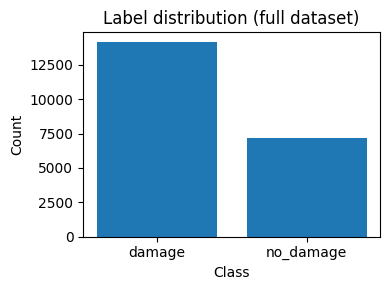

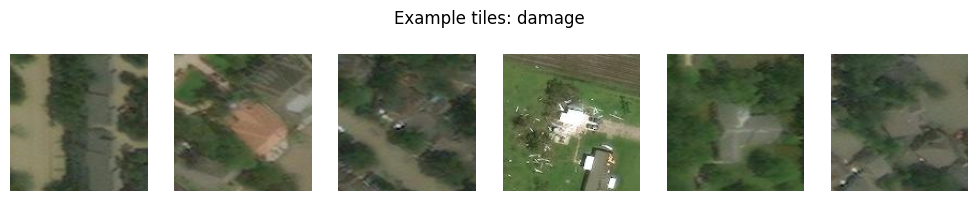

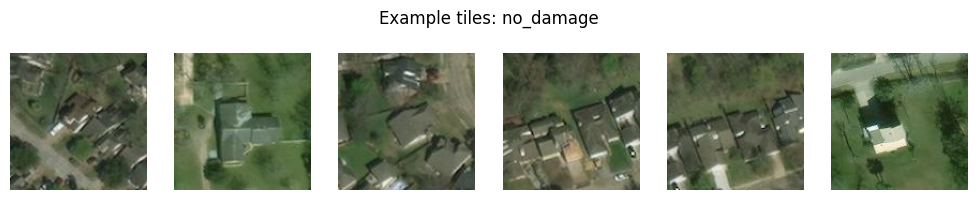

In [18]:
# aI suggested visualizations: label distribution + example images
import matplotlib.pyplot as plt

# 1) Label distribution for the full dataset
full_counts = Counter(labels)
plt.figure(figsize=(4, 3))
plt.bar(full_counts.keys(), full_counts.values())
plt.title("Label distribution (full dataset)")
plt.xlabel("Class")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

# 2) A few example images from each class
def show_examples(label, n=6):
    example_paths = [p for p, l in zip(paths, labels) if l == label][:n]
    plt.figure(figsize=(10, 2))
    for i, p in enumerate(example_paths):
        img = plt.imread(p)
        plt.subplot(1, n, i + 1)
        plt.imshow(img)
        plt.axis("off")
    plt.suptitle(f"Example tiles: {label}")
    plt.tight_layout()
    plt.show()

show_examples("damage", n=6)
show_examples("no_damage", n=6)


In [8]:
# Cell 3: Stratified split train/val/test
all_idx = np.arange(len(paths))
# test first
train_idx, test_idx = train_test_split(all_idx, test_size=TEST_SPLIT, stratify=labels, random_state=SEED)
# then val from train
train_idx, val_idx = train_test_split(train_idx, test_size=VAL_SPLIT/(1.0-TEST_SPLIT),
                                      stratify=labels[train_idx], random_state=SEED)

def subset(idx):
    return paths[idx], labels[idx]

train_paths, train_labels = subset(train_idx)
val_paths,   val_labels   = subset(val_idx)
test_paths,  test_labels  = subset(test_idx)

print("Split sizes:", len(train_paths), len(val_paths), len(test_paths))
print("Train label distribution:", Counter(train_labels))
print("Val   label distribution:", Counter(val_labels))
print("Test  label distribution:", Counter(test_labels))

# Label map
label_to_id = {"no_damage": 0, "damage": 1}
id_to_label = {v:k for k,v in label_to_id.items()}
json.dump(id_to_label, open(OUT_DIR/"label_map.json","w"))


Split sizes: 14925 3838 2559
Train label distribution: Counter({'damage': 9918, 'no_damage': 5007})
Val   label distribution: Counter({'damage': 2551, 'no_damage': 1287})
Test  label distribution: Counter({'damage': 1701, 'no_damage': 858})


In [9]:
# Cell 4: tf.data loaders with decoding & augmentation (per-model resize)
AUTO = tf.data.AUTOTUNE

def decode_img(path, img_size, to_gray=False):
    img = tf.io.read_file(path)
    img = tf.io.decode_image(img, channels=3, expand_animations=False)  # decode any
    img = tf.image.convert_image_dtype(img, tf.float32)
    if to_gray:
        img = tf.image.rgb_to_grayscale(img)
    img = tf.image.resize(img, img_size, method="bilinear", antialias=True)
    return img

def make_ds(paths, labels, img_size, to_gray=False, training=False, batch=BATCH):
    y = tf.constant([label_to_id[l] for l in labels], dtype=tf.int32)
    ds = tf.data.Dataset.from_tensor_slices((paths, y))
    def _load(p, y):
        x = decode_img(p, img_size, to_gray=to_gray)
        if training:
            # light aug to help generalization
            x = tf.image.random_flip_left_right(x)
            x = tf.image.random_flip_up_down(x)
            x = tf.image.random_brightness(x, 0.1)
            x = tf.image.random_contrast(x, 0.9, 1.1)
        return x, y
    ds = ds.shuffle(8192, seed=SEED) if training else ds
    ds = ds.map(_load, num_parallel_calls=AUTO).batch(batch).prefetch(AUTO)
    return ds

def class_weights(labels):
    counts = Counter(labels)
    total = sum(counts.values())
    return {label_to_id[k]: total/(len(counts)*v) for k,v in counts.items()}



In [11]:
# Cell 5: Model 1 – Dense ANN (flattened 64x64 grayscale)
def build_dense_ann(input_shape=(64,64,1)):
    inputs = keras.Input(shape=input_shape)
    x = layers.Flatten()(inputs)
    x = layers.Dense(512, activation="relu")(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(256, activation="relu")(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(64, activation="relu")(x)
    outputs = layers.Dense(1, activation="sigmoid")(x)
    return keras.Model(inputs, outputs, name="DenseANN")

ann_train = make_ds(train_paths, train_labels, ANN_IMG_SIZE, to_gray=True,  training=True)
ann_val   = make_ds(val_paths,   val_labels,   ANN_IMG_SIZE, to_gray=True,  training=False)
ann_test  = make_ds(test_paths,  test_labels,  ANN_IMG_SIZE, to_gray=True,  training=False)

ann = build_dense_ann((ANN_IMG_SIZE[0], ANN_IMG_SIZE[1], 1))
ann.compile(optimizer=keras.optimizers.Adam(1e-3),
            loss="binary_crossentropy",
            metrics=[keras.metrics.BinaryAccuracy(name="acc"), keras.metrics.AUC(name="auc")])

cw = class_weights(train_labels)
cb = [
    keras.callbacks.EarlyStopping(patience=4, restore_best_weights=True, monitor="val_auc", mode="max"),
    keras.callbacks.ReduceLROnPlateau(patience=2, factor=0.5, monitor="val_loss")
]
hist_ann = ann.fit(ann_train, validation_data=ann_val, epochs=EPOCHS, class_weight=cw, callbacks=cb)


Epoch 1/25
467/467 [==============================] - 8s 16ms/step - loss: 0.7243 - acc: 0.5030 - auc: 0.5116 - val_loss: 0.6990 - val_acc: 0.3825 - val_auc: 0.6863 - lr: 0.0010
Epoch 2/25
467/467 [==============================] - 7s 15ms/step - loss: 0.6924 - acc: 0.6149 - auc: 0.5133 - val_loss: 0.6823 - val_acc: 0.6647 - val_auc: 0.5004 - lr: 0.0010
Epoch 3/25
467/467 [==============================] - 7s 14ms/step - loss: 0.6949 - acc: 0.6543 - auc: 0.4936 - val_loss: 0.6909 - val_acc: 0.6647 - val_auc: 0.5000 - lr: 0.0010
Epoch 4/25
467/467 [==============================] - 7s 14ms/step - loss: 0.6933 - acc: 0.6081 - auc: 0.5007 - val_loss: 0.6940 - val_acc: 0.3353 - val_auc: 0.5000 - lr: 0.0010
Epoch 5/25
467/467 [==============================] - 7s 14ms/step - loss: 0.6933 - acc: 0.3388 - auc: 0.4947 - val_loss: 0.6935 - val_acc: 0.3353 - val_auc: 0.5000 - lr: 5.0000e-04


In [12]:
# Cell 6: Model 2 – Classic LeNet-5 (32x32 grayscale)
def build_lenet5(input_shape=(32,32,1), num_classes=1):
    inputs = keras.Input(shape=input_shape)
    x = layers.Conv2D(6, (5,5), activation="tanh", padding="valid")(inputs)
    x = layers.AveragePooling2D((2,2))(x)
    x = layers.Conv2D(16, (5,5), activation="tanh", padding="valid")(x)
    x = layers.AveragePooling2D((2,2))(x)
    x = layers.Conv2D(120, (5,5), activation="tanh", padding="valid")(x)
    x = layers.Flatten()(x)
    x = layers.Dense(84, activation="tanh")(x)
    outputs = layers.Dense(1, activation="sigmoid")(x)  # binary
    return keras.Model(inputs, outputs, name="LeNet5")

len_train = make_ds(train_paths, train_labels, LENET_IMG_SIZE, to_gray=True, training=True)
len_val   = make_ds(val_paths,   val_labels,   LENET_IMG_SIZE, to_gray=True, training=False)
len_test  = make_ds(test_paths,  test_labels,  LENET_IMG_SIZE, to_gray=True, training=False)

lenet5 = build_lenet5((LENET_IMG_SIZE[0], LENET_IMG_SIZE[1], 1))
lenet5.compile(optimizer=keras.optimizers.Adam(1e-3),
               loss="binary_crossentropy",
               metrics=[keras.metrics.BinaryAccuracy(name="acc"), keras.metrics.AUC(name="auc")])

hist_len = lenet5.fit(len_train, validation_data=len_val, epochs=EPOCHS, class_weight=cw, callbacks=cb)


Epoch 1/25
467/467 [==============================] - 5s 9ms/step - loss: 0.6533 - acc: 0.6171 - auc: 0.6667 - val_loss: 0.6462 - val_acc: 0.6245 - val_auc: 0.6924 - lr: 0.0010
Epoch 2/25
467/467 [==============================] - 5s 10ms/step - loss: 0.6314 - acc: 0.6482 - auc: 0.6974 - val_loss: 0.6323 - val_acc: 0.6475 - val_auc: 0.7208 - lr: 0.0010
Epoch 3/25
467/467 [==============================] - 5s 10ms/step - loss: 0.6225 - acc: 0.6636 - auc: 0.7064 - val_loss: 0.6023 - val_acc: 0.6842 - val_auc: 0.7162 - lr: 0.0010
Epoch 4/25
467/467 [==============================] - 5s 10ms/step - loss: 0.6145 - acc: 0.6647 - auc: 0.7175 - val_loss: 0.6077 - val_acc: 0.6746 - val_auc: 0.7352 - lr: 0.0010
Epoch 5/25
467/467 [==============================] - 4s 9ms/step - loss: 0.6052 - acc: 0.6795 - auc: 0.7317 - val_loss: 0.5543 - val_acc: 0.7280 - val_auc: 0.7622 - lr: 0.0010
Epoch 6/25
467/467 [==============================] - 5s 10ms/step - loss: 0.5937 - acc: 0.6937 - auc: 0.7464 - 

In [13]:
# Cell 7: Model 3 – Alternate-LeNet (based off the paper’s Table 1)
def build_alt_lenet(input_shape=(150,150,3)):
    inputs = keras.Input(shape=input_shape)
    x = layers.Conv2D(32, (3,3), activation="relu", padding="valid")(inputs) # 148x148x32
    x = layers.MaxPooling2D((2,2))(x) # 4x74x32
    x = layers.Conv2D(64, (3,3), activation="relu", padding="valid")(x) # 72x72x64
    x = layers.MaxPooling2D((2,2))(x) # 36x36x64
    x = layers.Conv2D(128,(3,3), activation="relu", padding="valid")(x) # 34x34x128
    x = layers.MaxPooling2D((2,2))(x) # 17x17x128
    x = layers.Conv2D(128,(3,3), activation="relu", padding="valid")(x) # 15x15x128
    x = layers.MaxPooling2D((2,2))(x) # 7x7x128
    x = layers.Flatten()(x) # 6272
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(512, activation="relu")(x)
    outputs = layers.Dense(1, activation="sigmoid")(x)
    return keras.Model(inputs, outputs, name="AltLeNetPaper")

alt_train = make_ds(train_paths, train_labels, ALT_IMG_SIZE, to_gray=False, training=True)
alt_val   = make_ds(val_paths,   val_labels,   ALT_IMG_SIZE, to_gray=False, training=False)
alt_test  = make_ds(test_paths,  test_labels,  ALT_IMG_SIZE, to_gray=False, training=False)

alt = build_alt_lenet((ALT_IMG_SIZE[0], ALT_IMG_SIZE[1], 3))
alt.compile(optimizer=keras.optimizers.Adam(3e-4),   # a little lower LR for stability
            loss="binary_crossentropy",
            metrics=[keras.metrics.BinaryAccuracy(name="acc"), keras.metrics.AUC(name="auc")])

cb_alt = [
    keras.callbacks.ModelCheckpoint(str(OUT_DIR/"alt_checkpoint.keras"),
                                    monitor="val_auc", mode="max", save_best_only=True),
    keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True, monitor="val_auc", mode="max"),
    keras.callbacks.ReduceLROnPlateau(patience=2, factor=0.5)
]
hist_alt = alt.fit(alt_train, validation_data=alt_val, epochs=EPOCHS, class_weight=cw, callbacks=cb_alt)


Epoch 1/25
467/467 [==============================] - 139s 296ms/step - loss: 0.4275 - acc: 0.7940 - auc: 0.8881 - val_loss: 0.2073 - val_acc: 0.9195 - val_auc: 0.9723 - lr: 3.0000e-04
Epoch 2/25
467/467 [==============================] - 139s 297ms/step - loss: 0.2208 - acc: 0.9151 - auc: 0.9704 - val_loss: 0.1202 - val_acc: 0.9510 - val_auc: 0.9896 - lr: 3.0000e-04
Epoch 3/25
467/467 [==============================] - 142s 305ms/step - loss: 0.1733 - acc: 0.9327 - auc: 0.9817 - val_loss: 0.1107 - val_acc: 0.9591 - val_auc: 0.9925 - lr: 3.0000e-04
Epoch 4/25
467/467 [==============================] - 140s 301ms/step - loss: 0.1524 - acc: 0.9423 - auc: 0.9859 - val_loss: 0.1157 - val_acc: 0.9560 - val_auc: 0.9912 - lr: 3.0000e-04
Epoch 5/25
467/467 [==============================] - 147s 314ms/step - loss: 0.1347 - acc: 0.9483 - auc: 0.9886 - val_loss: 0.1204 - val_acc: 0.9513 - val_auc: 0.9937 - lr: 3.0000e-04
Epoch 6/25
467/467 [==============================] - 145s 310ms/step - los

In [15]:
# Cell 8: Evaluation stuff
def evaluate_keras(model, ds, name):
    y_true, y_prob = [], []
    for x, y in ds:
        p = model.predict(x, verbose=0).ravel()
        y_prob.extend(p.tolist())
        y_true.extend(y.numpy().ravel().tolist())
    y_pred = (np.array(y_prob) >= 0.5).astype(int)
    f1 = f1_score(y_true, y_pred)
    auc = roc_auc_score(y_true, y_prob)
    report = classification_report(y_true, y_pred, target_names=["no_damage","damage"])
    cm = confusion_matrix(y_true, y_pred)
    print(f"\n{name} - F1: {f1:.4f}  AUC: {auc:.4f}\n")
    print(report)
    print("Confusion matrix:\n", cm)
    return {"f1": f1, "auc": auc}

res_ann = evaluate_keras(ann, ann_val, "DenseANN (val)")
res_len = evaluate_keras(lenet5, len_val, "LeNet5 (val)")
res_alt = evaluate_keras(alt, alt_val, "AltLeNet (val)")

results = {"DenseANN":res_ann, "LeNet5":res_len, "AltLeNet":res_alt}
print("VAL COMPARISON:", results)



DenseANN (val) - F1: 0.1432  AUC: 0.6903

              precision    recall  f1-score   support

   no_damage       0.35      0.99      0.52      1287
      damage       0.92      0.08      0.14      2551

    accuracy                           0.38      3838
   macro avg       0.64      0.53      0.33      3838
weighted avg       0.73      0.38      0.27      3838

Confusion matrix:
 [[1270   17]
 [2353  198]]

LeNet5 (val) - F1: 0.7829  AUC: 0.8008

              precision    recall  f1-score   support

   no_damage       0.58      0.70      0.63      1287
      damage       0.83      0.74      0.78      2551

    accuracy                           0.73      3838
   macro avg       0.70      0.72      0.71      3838
weighted avg       0.74      0.73      0.73      3838

Confusion matrix:
 [[ 895  392]
 [ 658 1893]]

AltLeNet (val) - F1: 0.9872  AUC: 0.9986

              precision    recall  f1-score   support

   no_damage       0.96      0.99      0.98      1287
      damage      

In [17]:
# Cell 9: Select best by validation F1, test once, save model and label_map
best_name = max(results, key=lambda k: results[k]["f1"])
best_model = {"DenseANN":ann, "LeNet5":lenet5, "AltLeNet":alt}[best_name]
print("Selected best model:", best_name)

# Final test metrics
ds_test = {"DenseANN":ann_test, "LeNet5":len_test, "AltLeNet":alt_test}[best_name]
test_metrics = evaluate_keras(best_model, ds_test, f"{best_name} (test)")

# saved model in Keras format
best_path = OUT_DIR/"best_model.keras"
best_model.save(best_path)
print("Saved:", best_path)

# JSON summary for server
summary = {
    "model_name": best_name,
    "val": results[best_name],
    "test": test_metrics,
    "input_size": {"DenseANN":ANN_IMG_SIZE, "LeNet5":LENET_IMG_SIZE, "AltLeNet":ALT_IMG_SIZE}[best_name],
    "input_mode": "grayscale" if best_name in ("DenseANN","LeNet5") else "rgb",
    "created_with": "TensorFlow/Keras"
}
json.dump(summary, open(OUT_DIR/"summary.json","w"))
print(json.dumps(summary, indent=2))


Selected best model: AltLeNet

AltLeNet (test) - F1: 0.9900  AUC: 0.9992

              precision    recall  f1-score   support

   no_damage       0.97      0.99      0.98       858
      damage       0.99      0.99      0.99      1701

    accuracy                           0.99      2559
   macro avg       0.98      0.99      0.99      2559
weighted avg       0.99      0.99      0.99      2559

Confusion matrix:
 [[ 847   11]
 [  23 1678]]
Saved: /code/project2/models/best_model.keras
{
  "model_name": "AltLeNet",
  "val": {
    "f1": 0.9871870687955844,
    "auc": 0.9986165670211143
  },
  "test": {
    "f1": 0.9899705014749263,
    "auc": 0.9992449251708512
  },
  "input_size": [
    150,
    150
  ],
  "input_mode": "rgb",
  "created_with": "TensorFlow/Keras"
}
